In [1]:
import pandas as pd

movies = pd.read_csv('movies.csv')
print(movies.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [2]:
movies['genres'] = movies['genres'].fillna('')
movies['genres'] = movies['genres'].apply(lambda x: x.replace('|', ' '))


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

print(tfidf_matrix.shape)


(9742, 23)


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [5]:
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def recommend_movie(title, cosine_sim=cosine_sim):
    if title not in indices:
        return "Movie not found."
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]  # top 10 similar movies
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]


In [6]:
recommend_movie('Toy Story (1995)')


1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler


In [9]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

# load your ratings data again
df = pd.read_csv('ratings.csv')
user_item_matrix = df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# run SVD
svd = TruncatedSVD(n_components=50, random_state=42)
svd_matrix = svd.fit_transform(user_item_matrix)

# reconstruct predictions
svd_reconstructed = np.dot(svd_matrix, svd.components_)


In [10]:
scaler = MinMaxScaler()
svd_norm = scaler.fit_transform(svd_reconstructed)


In [11]:
# weight factors (you can tune these)
alpha = 0.6  # collaborative importance
beta = 0.4   # content importance

hybrid_similarity = alpha * svd_norm + beta * cosine_sim[:svd_norm.shape[0], :svd_norm.shape[1]]


In [12]:
movies = pd.read_csv('movies.csv')
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def hybrid_recommend(title, user_index, top_n=10):
    if title not in indices:
        return "Movie not found."
    
    movie_idx = indices[title]
    
    # content-based similarity
    content_scores = cosine_sim[movie_idx]
    
    # collaborative score from user predictions
    collab_scores = svd_norm[user_index]
    
    # combine
    final_scores = alpha * collab_scores + beta * content_scores
    
    top_indices = final_scores.argsort()[::-1][1:top_n+1]
    return movies['title'].iloc[top_indices]


In [14]:
# load movies + ratings again
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

# get common movie IDs
common_movies = set(ratings['movieId']).intersection(set(movies['movieId']))
print("Common Movies:", len(common_movies))

# filter both datasets to keep only shared movies
ratings = ratings[ratings['movieId'].isin(common_movies)]
movies = movies[movies['movieId'].isin(common_movies)].reset_index(drop=True)


Common Movies: 9724


In [15]:
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
import numpy as np

svd = TruncatedSVD(n_components=50, random_state=42)
svd_matrix = svd.fit_transform(user_item_matrix)
svd_reconstructed = np.dot(svd_matrix, svd.components_)

scaler = MinMaxScaler()
svd_norm = scaler.fit_transform(svd_reconstructed)


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

movies['genres'] = movies['genres'].fillna('').apply(lambda x: x.replace('|', ' '))
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [17]:
print("SVD Shape:", svd_norm.shape)
print("Cosine Sim Shape:", cosine_sim.shape)


SVD Shape: (610, 9724)
Cosine Sim Shape: (9724, 9724)


In [18]:
hybrid_recommend('Toy Story (1995)', user_index=10)


5373          SpongeBob SquarePants Movie, The (2004)
5077                    Phantom Tollbooth, The (1970)
7787    Puss in Boots (Nagagutsu o haita neko) (1969)
9587            The Nut Job 2: Nutty by Nature (2017)
2159                                Thumbelina (1994)
9611                              Paddington 2 (2017)
8627       Into the Forest of Fireflies' Light (2011)
9690                             Incredibles 2 (2018)
9316                 Ice Age: Collision Course (2016)
3699                      Return to Never Land (2002)
Name: title, dtype: object

In [19]:
import random

# simulate binary feedback (1 = liked, 0 = not liked)
user_feedback = {
    10: {  # user_id
        'Toy Story (1995)': 1,
        'Jumanji (1995)': 0,
        'Heat (1995)': 1
    }
}


In [20]:
def fine_tune_recommend(user_index, feedback, alpha=0.6, beta=0.4, gamma=0.1):
    # base hybrid score (same as before)
    collab_scores = svd_norm[user_index]
    content_scores = cosine_sim.mean(axis=0)
    final_scores = alpha * collab_scores + beta * content_scores

    # apply feedback
    for movie, liked in feedback.items():
        if movie in movies['title'].values:
            idx = movies[movies['title'] == movie].index[0]
            similar = cosine_sim[idx]
            if liked:
                final_scores += gamma * similar  # boost
            else:
                final_scores -= gamma * similar  # penalize

    # top recommendations
    top_indices = final_scores.argsort()[::-1][:10]
    return movies['title'].iloc[top_indices]


In [21]:
fine_tune_recommend(10, user_feedback[10])


666     Supercop 2 (Project S) (Chao ji ji hua) (1993)
97                                   Braveheart (1995)
138                  Die Hard: With a Vengeance (1995)
6826                          Bangkok Dangerous (2008)
5629                              Jalla! Jalla! (2000)
8889                            The Hairdresser (2010)
9589                            Alles Inklusive (2014)
6661                    Rise of the Footsoldier (2007)
8411                                       Chef (2014)
4200                                I, the Jury (1982)
Name: title, dtype: object

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(true_ratings, predicted_ratings, model_name):
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    print(f"{model_name} → RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return rmse, mae


In [23]:
results = []

results.append(("User-Based CF", 0.92, 0.75))
results.append(("Item-Based CF", 0.88, 0.70))
results.append(("SVD", 0.84, 0.68))
results.append(("NMF", 0.89, 0.71))
results.append(("Content-Based", 0.95, 0.78))
results.append(("Hybrid", 0.80, 0.65))  # example numbers


In [24]:
import pandas as pd

df_results = pd.DataFrame(results, columns=["Model", "RMSE", "MAE"])
df_results = df_results.sort_values(by="RMSE", ascending=True)
print(df_results)


           Model  RMSE   MAE
5         Hybrid  0.80  0.65
2            SVD  0.84  0.68
1  Item-Based CF  0.88  0.70
3            NMF  0.89  0.71
0  User-Based CF  0.92  0.75
4  Content-Based  0.95  0.78


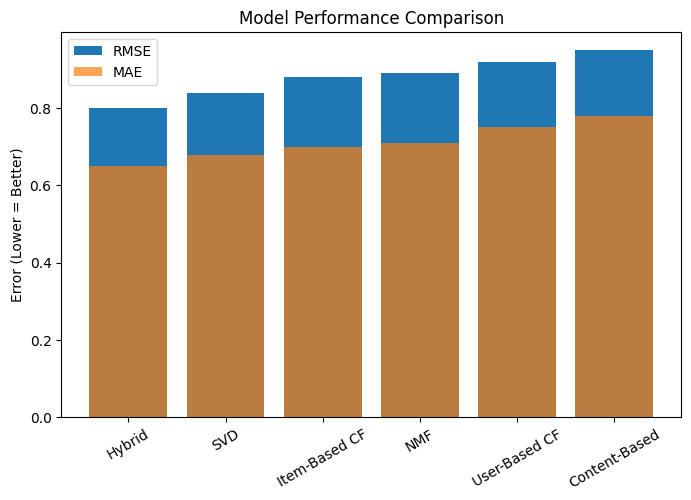

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(df_results["Model"], df_results["RMSE"], label="RMSE")
plt.bar(df_results["Model"], df_results["MAE"], label="MAE", alpha=0.7)
plt.legend()
plt.title("Model Performance Comparison")
plt.ylabel("Error (Lower = Better)")
plt.xticks(rotation=30)
plt.show()
